# Create initialization files for double-gyre simulation
Code creates initialization files with vertical profiles of temperature & salinity (WOA); total CO2 & alkalinity (Glodap); nitrate, oxygen, phosphate & silicate (WOA); and the same global model output as Enhui for the rest (`cobalt_tracer_source.nc` and `init_ocean_cobalt_nh3.res.nc`)

### Script output
- `DG_init_TS.nc`: initialization profiles for T & S (temp & salt; truncated at 1000 m)
- `DG_init_TCO2_TAlk.nc`: initialization profiles for total carbon & alkalinity (TCO2 & TAlk)
- `DG_init_NOPI.nc`: initialization profiles for nitrate, oxygen, phosphate & silicate (n_an, o_an, p_an, i_an)
- `DG_init_tracers.nc`: initialization profiles for other tracers

### From Lévy et al. (2010):
Initialized at rest with vertical profiles of temperature and salinity uniformly applied to the whole domain. The profiles were constructed from the World Ocean Atlas climatologies by averaging over 25–30°N and 80–0°W. The profiles were truncated to constant values below 1000 m in order to allow faster equilibration of deep waters (which are not of interest here) and to facilitate deep convection in the absence of intermittent forcings. 

### Notes:
- WOA longitude is from -180 to 180
- Glodap longitude is from 0 to 360
- Enhui uses potential temperature (referenced to 0 m, using EOS80), but since we are already truncating below 1000 m and the maximum difference at 4000 m is 0.26C between potential and in situ temperature, ignored conversion
- COBALT simulations used to initialize profiles are quite large, so left in original folder:
`/tigress/GEOCLIM/LRGROUP/datasets_2020_Jan/cobalt_data_0406_2020/`


In [2]:
import os
import cftime
import xarray as xr
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

In [3]:
# Paths
spath = '../../init/WOA-SOCAT-ESM/'  # Save initialization files
fpath = './'  # Save figures 
wpath = '/projects/GEOCLIM/LRGROUP/shared_data/woa18/' # WOA dataset
gpath = '/projects/GEOCLIM/LRGROUP/shared_data/glodap/GLODAPv2.2016b_MappedClimatologies/'  # GLODAP
mpath = '/projects/GEOCLIM/LRGROUP/datasets_2020_Jan/cobalt_data_0406_2020/'  # Global model output

# Manual input
fillval = -1e+20  # set fill value (Raphael/Enhui: -1e+20; Elizabeth:-1.e+34)

# Area over which to average (based on Lévy et al. 2010)
latA1 = 19 
latA2 = 61
lonA1 = 360-80
lonA2 = 360-40
depA1 = 0
depA2 = 4000

# Gridded output (consistent with surface forcing)
latG1 = 15
latG2 = 65
lonG1 = 300
lonG2 = 350
depG1 = 0
depG2 = 4000

dx = 0.5  # half-degree resolution
dy = 0.5

# Figure parameters
params  = {'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'legend.fontsize': 12,
          'axes.linewidth': 2,
          'figure.facecolor': 'white',}


In [4]:
# Create vectors
longitude = np.arange(lonG1, lonG2, dx)
longitude = np.resize(longitude, (len(longitude), 1))
latitude  = np.arange(latG1, latG2, dy)
latitude  = np.resize(latitude, (len(latitude), 1))
Time      = 1

# Sample files for reference

In [4]:
# Path to a sample file to build
# rpath = '/projects/GEOCLIM/LRGROUP/jc5136/SetupFiles/SampleFiles/'  

# T/S
# dsRef = xr.open_dataset(rpath + 'woa13_decav_s_monthly_fulldepth_01.nc')

# Current file is quite complicated, perhaps Elizabeth's is better to look at for bare minimum
# Current file has 12 profiles (annual cycle); using one profile for our initialization files 
# dsRef.note
# dsRef.depth

# TCO2
# dsRef = xr.open_dataset(rpath + 'TCO2_v2_correct_to_1958.nc', drop_variables='Time')
# dsRef.TCO2

# TAlk
# dsRef = xr.open_dataset(rpath + 'TAlk_v2.nc', drop_variables='Time')
# dsRef.Alk

# NO3
# dsRef = xr.open_dataset(rpath + 'woa13_all_n_annual_01.nc', decode_times=False)

# Temperature & Salinity
Start with temperature and salinity because format can be tested in physics only model

Enhui's simulation uses:
- time 
- depth
- lat 
- lon
- ptemp_an or s_an (time, depth, lat, lon)

In [5]:
# Load WOA18 dataset
dsT = xr.open_dataset(wpath + 'temp/1deg/woa18_decav_t00_01.nc', decode_times=False)
dsS = xr.open_dataset(wpath + 'salt/1deg/woa18_decav_s00_01.nc', decode_times=False)

# Use objectively analyze mean fields (an) instead of mean (mn)
# Extract profile 
profT = dsT.t_an.sel(lat=slice(latA1, latA2), lon=slice(lonA1-360, lonA2-360), depth = slice(depA1, depA2)).mean(dim={'lon','time'}, skipna=True)
profS = dsS.s_an.sel(lat=slice(latA1, latA2), lon=slice(lonA1-360, lonA2-360), depth = slice(depA1, depA2)).mean(dim={'lon','time'}, skipna=True)

# Isolate other dimensions
depth0   = profT.depth.values
depth0   = np.resize(depth0, (depth0.size, 1)).T[0]

temp0 = profT.interp(depth = depth0, lat = latitude.T[0], kwargs={"fill_value": "extrapolate"}).values
salt0 = profS.interp(depth = depth0, lat = latitude.T[0], kwargs={"fill_value": "extrapolate"}).values

temp0[depth0 > 3000] = temp0[depth0 == 3000]
salt0[depth0 > 3000] = salt0[depth0 == 3000]

# Repeat the profile everywhere in our domain
t_in    = np.array([temp0 for i in range(len(longitude))])
t_in    = np.transpose(t_in, (1,2,0))  # depth, latitude, longitude
t_in    = np.expand_dims(t_in, 0)  # add an extra dimension for 'time' (just one time step)

s_in    = np.array([salt0 for i in range(len(longitude))])
s_in    = np.transpose(s_in, (1,2,0))  # depth, latitude, longitude
s_in    = np.expand_dims(s_in, 0)  # add an extra dimension for 'time' (just one time step)

# Replace NaNs with small value
t_in[np.isnan(t_in)] = fillval
s_in[np.isnan(s_in)] = fillval

Text(0.5, 1.0, 'Salinity')

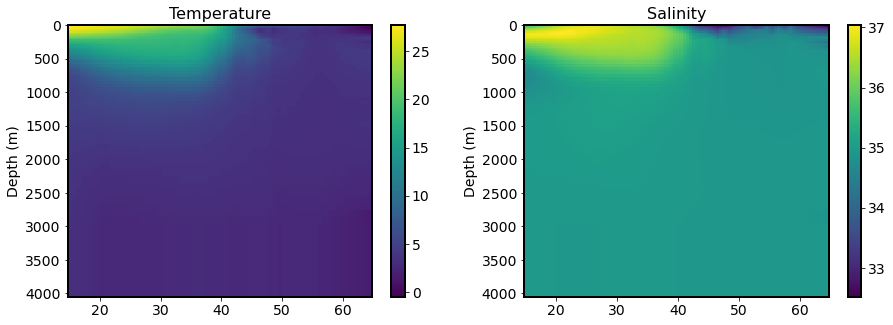

In [6]:
plot_lon = False

### Figure - check ###
plt.rcParams.update(params)

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
axs = axs.flatten()

if plot_lon:
    pC = axs[0].pcolormesh(longitude.T, depth0, t_in[0,:,0,:])
    fig.colorbar(pC, ax=axs[0])

    pA = axs[1].pcolormesh(longitude.T, depth0, s_in[0,:,0,:])
    fig.colorbar(pA, ax=axs[1])

#Transect across latitude shows the same pattern
else:
    pT = axs[0].pcolormesh(latitude.transpose(), depth0, t_in[0,:,:,0])
    fig.colorbar(pT, ax=axs[0])

    pS = axs[1].pcolormesh(latitude.transpose(), depth0, s_in[0,:,:,0])
    fig.colorbar(pS, ax=axs[1])


axs[0].invert_yaxis()
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('Temperature')

axs[1].invert_yaxis()
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('Salinity')


In [7]:
# From Elizabeth's MOM6 Example
writing = nc.Dataset(spath + "DG_init_TS.nc","w",format="NETCDF3_64BIT_OFFSET")
time    = writing.createDimension("time", 1)
depth   = writing.createDimension("depth", len(depth0))
lat     = writing.createDimension("lat", len(latitude))
lon     = writing.createDimension("lon", len(longitude))

lat     = writing.createVariable("lat","f8",("lat"))
lat[:]  = latitude
lat.standard_name    = "latitude"
lat.units            = "degrees_north"
lat.cartesian_axis   = "Y"
 
lon     = writing.createVariable("lon","f8",("lon"))
lon[:]  = longitude
lon.standard_name    = "longitude"
lon.units            = "degrees_east"
lon.cartesian_axis   = "X" ;

time    = writing.createVariable("time","f8",("time"))
time[:] = 0.0
time.standard_name   = "time"
time.units           = "days since 0001-01-01 00:00:00"
time.calendar        = "noleap" ;
time.cartesian_axis  = "T" ;
    
depth    = writing.createVariable("depth","f8",("depth"))
depth[:] = depth0
depth.standard_name  = "depth"
depth.units          = "m"
depth.positive       = "down"
depth.cartesian_axis = "Z" ;

temp          = writing.createVariable("temp","f4",("time","depth","lat","lon"),fill_value=fillval)
temp[:,:,:,:] = t_in
temp.standard_name   = "Initial temperature"
temp.units           = "Celsius"
temp.description     = "from WOA18 decav 00 1deg, averaged over N25–30 and W80–0"

salt          = writing.createVariable("salt","f4",("time","depth","lat","lon"),fill_value=fillval)
salt[:,:,:,:] = s_in
salt.standard_name   = "Initial salinity"
salt.units           = "PSU"
salt.description     = "from WOA18 decav 00 1deg, averaged over N25–30 and W80–0"

writing.close()

In [8]:
# Check file - works with ice_ocean model
# ds = xr.open_dataset(spath + 'DG_init_TS.nc')
# ds

# Total carbon & total alkalinity

### Enhui's initialization file has:
- longitude (n X 1)
- latitude (n X 1)
- depth (n X 1)
- TCO2 (longitude, latitude, depth, time)
- TCO2Err (same as TCO2)
- time (1 X 1)

### Notes
- Using 2016 GLODAP mapped product because appears to be the most recent
- Dimensions of Enhui's TCO2 are not in the same order as for physical initialization files; try swapping to be consistent with above...
- Add a description of how the files were generated.


In [9]:
# Load file
dsC = xr.open_dataset(gpath + 'GLODAPv2.2016b.TCO2.nc')
dsA = xr.open_dataset(gpath + 'GLODAPv2.2016b.TAlk.nc')

In [10]:
# Extract profCile - do we need to dump some variables?
profC = dsC.sel(lat=slice(latA1, latA2), lon=slice(lonA1, lonA2)).mean(dim={'lon'}, skipna=True)
profC = xr.DataArray(data=profC.TCO2.values, dims=["depth", "lat"], coords=dict(depth=profC.Depth.values,lat=profC.lat))

profA = dsA.sel(lat=slice(latA1, latA2), lon=slice(lonA1, lonA2)).mean(dim={'lon'}, skipna=True)
profA = xr.DataArray(data=profA.TAlk.values, dims=["depth", "lat"], coords=dict(depth=profA.Depth.values,lat=profA.lat))

# Isolate other dimensions
depth0   = profT.depth.values
depth0   = np.resize(depth0, (depth0.size, 1)).T[0]

TCO20 = profC.interp(depth = depth0, lat = latitude.T[0], kwargs={"fill_value": "extrapolate"}).values
TAlk0 = profA.interp(depth = depth0, lat = latitude.T[0], kwargs={"fill_value": "extrapolate"}).values

TCO20[depth0 > 3000] = TCO20[depth0 == 3000]
TAlk0[depth0 > 3000] = TAlk0[depth0 == 3000]

# Repeat the profile everywhere in our domain
TCO2_in    = np.array([TCO20 for i in range(len(longitude))])
TCO2_in    = np.transpose(TCO2_in, (1,2,0))  # depth, latitude, longitude
TCO2_in    = np.expand_dims(TCO2_in, 0)  # add an extra dimension for 'time' (just one time step)

TAlk_in    = np.array([TAlk0 for i in range(len(longitude))])
TAlk_in    = np.transpose(TAlk_in, (1,2,0))  # depth, latitude, longitude
TAlk_in    = np.expand_dims(TAlk_in, 0)  # add an extra dimension for 'time' (just one time step)

# Replace NaNs with small value
TCO2_in[np.isnan(TCO2_in)] = fillval
TAlk_in[np.isnan(TAlk_in)] = fillval

Text(0.5, 1.0, 'TAlk')

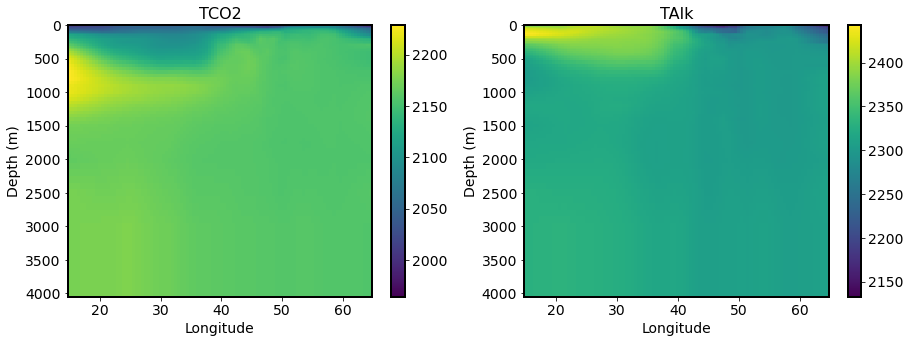

In [11]:
plot_lon = False

### Figure - check ###
plt.rcParams.update(params)

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
axs = axs.flatten()

if plot_lon:
    pC = axs[0].pcolormesh(longitude.T, depth0, TCO2_in[0,:,0,:])
    fig.colorbar(pC, ax=axs[0])

    pA = axs[1].pcolormesh(longitude.T, depth0, TAlk_in[0,:,0,:])
    fig.colorbar(pA, ax=axs[1])

#Transect across latitude shows the same pattern
else:
    pT = axs[0].pcolormesh(latitude.transpose(), depth0, TCO2_in[0,:,:,0])
    fig.colorbar(pT, ax=axs[0])

    pS = axs[1].pcolormesh(latitude.transpose(), depth0, TAlk_in[0,:,:,0])
    fig.colorbar(pS, ax=axs[1])

axs[0].invert_yaxis()
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('TCO2')

axs[1].invert_yaxis()
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('TAlk')


In [12]:
# From Elizabeth's MOM6 Example
writing = nc.Dataset(spath + "DG_init_TCO2_TAlk.nc","w",format="NETCDF3_64BIT_OFFSET")
time    = writing.createDimension("time", 1)
depth   = writing.createDimension("depth", len(depth0))
lat     = writing.createDimension("lat", len(latitude))
lon     = writing.createDimension("lon", len(longitude))

lat     = writing.createVariable("lat","f8",("lat"))
lat[:]  = latitude
lat.standard_name    = "latitude"
lat.units            = "degrees_north"
lat.cartesian_axis   = "Y"
 
lon     = writing.createVariable("lon","f8",("lon"))
lon[:]  = longitude
lon.standard_name    = "longitude"
lon.units            = "degrees_east"
lon.cartesian_axis   = "X" ;

time    = writing.createVariable("time","f8",("time"))
time[:] = 0.0
time.standard_name   = "time"
time.units           = "days since 0001-01-01 00:00:00"
time.calendar        = "noleap" ;
time.cartesian_axis  = "T" ;
    
depth    = writing.createVariable("depth","f8",("depth"))
depth[:] = depth0
depth.standard_name  = "depth"
depth.units          = "m"
depth.positive       = "down"
depth.cartesian_axis = "Z" ;

TCO2          = writing.createVariable("TCO2","f4",("time","depth","lat","lon"),fill_value=fillval)
TCO2[:,:,:,:] = TCO2_in
TCO2.long_name      = "moles of dissolved inorganic carbon per unit mass in seawater"
TCO2.units          = "micro-mol kg-1"
TCO2.description    = "from GLODAPv2.2016b mapped product, averaged over N25–30 and W80–0"

TAlk          = writing.createVariable("TAlk","f4",("time","depth","lat","lon"),fill_value=fillval)
TAlk[:,:,:,:] = TAlk_in
TAlk.long_name      = "seawater alkalinity expressed as mole equivalent per unit mass"
TAlk.units          = "micro-mol kg-1"
TAlk.description    = "from GLODAPv2.2016b mapped product, averaged over N25–30 and W80–0"
 
writing.close()


In [13]:
# Check file - works with ice_ocean model
# ds = xr.open_dataset(spath + 'DG_init_TCO2_TAlk.nc')
# ds

# Nitrate, Oxygen, Phosphate & Silicate

Enhui's simulations use `n_an`, `o_an`, `p_an` and `i_an` from WOA13. Will use WOA18. 

### Notes:

In [14]:
# WOA18 dataset
dsN = xr.open_dataset(wpath + 'nitrate/woa18_all_n00_01.nc', decode_times=False)
dsO = xr.open_dataset(wpath + 'oxygen/woa18_all_o00_01.nc', decode_times=False)
dsP = xr.open_dataset(wpath + 'phosphate/woa18_all_p00_01.nc', decode_times=False)
dsI = xr.open_dataset(wpath + 'silicate/woa18_all_i00_01.nc', decode_times=False)
# numbers after n, o, p or i indicate seasons; 00 is annual
# os.listdir(wpath + 'silicate')

In [15]:
# Use objectively analyze mean fields (an) 
# Extract profile 
profN = dsN.n_an.sel(lat=slice(latA1, latA2), lon=slice(lonA1-360, lonA2-360)).mean(dim={'lon','time'}, skipna=True)
profO = dsO.o_an.sel(lat=slice(latA1, latA2), lon=slice(lonA1-360, lonA2-360)).mean(dim={'lon','time'}, skipna=True)
profP = dsP.p_an.sel(lat=slice(latA1, latA2), lon=slice(lonA1-360, lonA2-360)).mean(dim={'lon','time'}, skipna=True)
profI = dsI.i_an.sel(lat=slice(latA1, latA2), lon=slice(lonA1-360, lonA2-360)).mean(dim={'lon','time'}, skipna=True)

# Isolate other dimensions
depth0   = profN.depth.values
depth0   = np.resize(depth0, (depth0.size, 1)).T[0]

profN = profN.interp(depth = depth0, lat = latitude.T[0], kwargs={"fill_value": "extrapolate"}).values
profO = profO.interp(depth = depth0, lat = latitude.T[0], kwargs={"fill_value": "extrapolate"}).values
profP = profP.interp(depth = depth0, lat = latitude.T[0], kwargs={"fill_value": "extrapolate"}).values
profI = profI.interp(depth = depth0, lat = latitude.T[0], kwargs={"fill_value": "extrapolate"}).values

profN[depth0 > 3000] = profN[depth0 == 3000]
profO[depth0 > 3000] = profO[depth0 == 3000]
profP[depth0 > 3000] = profP[depth0 == 3000]
profI[depth0 > 3000] = profI[depth0 == 3000]

# Repeat the profile everywhere in our domain
n_in    = np.array([profN for i in range(len(longitude))])
n_in    = np.transpose(n_in, (1,2,0))  # depth, latitude, longitude
n_in    = np.expand_dims(n_in, 0)  # add an extra dimension for 'time' (just one time step)

o_in    = np.array([profO for i in range(len(longitude))])
o_in    = np.transpose(o_in, (1,2,0))  # depth, latitude, longitude
o_in    = np.expand_dims(o_in, 0)  # add an extra dimension for 'time' (just one time step)
o_in    = o_in/42.97 # umol/kg -> mL/L

p_in    = np.array([profP for i in range(len(longitude))])
p_in    = np.transpose(p_in, (1,2,0))  # depth, latitude, longitude
p_in    = np.expand_dims(p_in, 0)  # add an extra dimension for 'time' (just one time step)

i_in    = np.array([profI for i in range(len(longitude))])
i_in    = np.transpose(i_in, (1,2,0))  # depth, latitude, longitude
i_in    = np.expand_dims(i_in, 0)  # add an extra dimension for 'time' (just one time step)

# Replace NaNs with small value
n_in[np.isnan(n_in)] = fillval
o_in[np.isnan(o_in)] = fillval
p_in[np.isnan(p_in)] = fillval
i_in[np.isnan(i_in)] = fillval

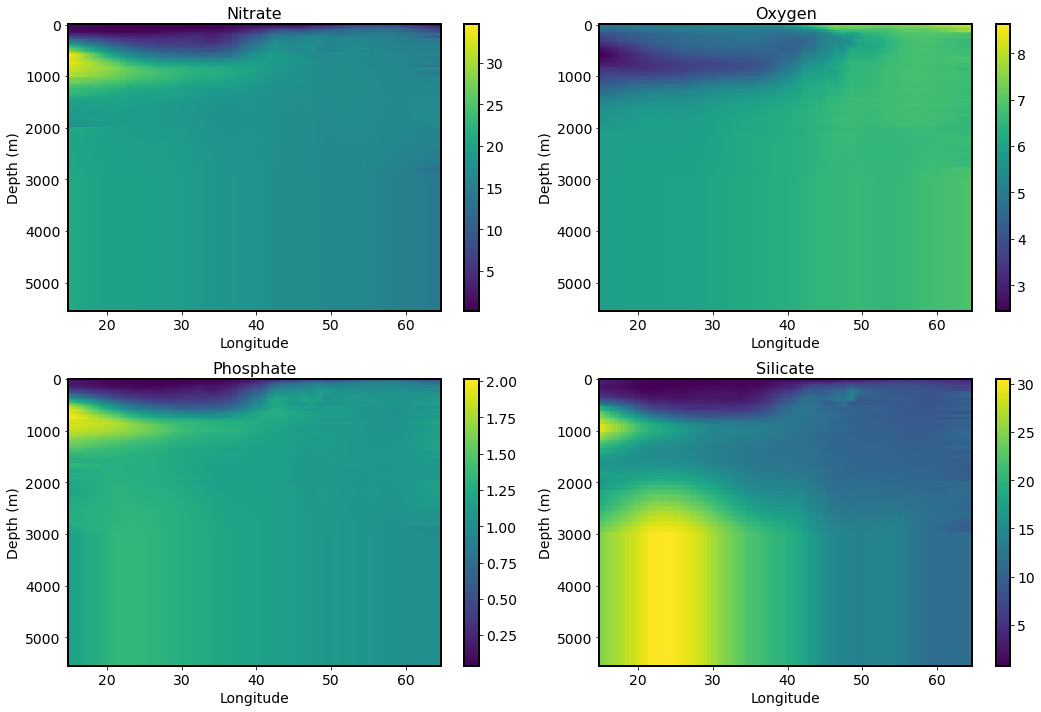

In [16]:
plot_lon = False

### Figure - check ###
plt.rcParams.update(params)

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
axs = axs.flatten()

if plot_lon:
    pN = axs[0].pcolormesh(longitude.T, depth0, n_in[0,:,0,:])
    fig.colorbar(pN, ax=axs[0])
    pO = axs[1].pcolormesh(longitude.T, depth0, o_in[0,:,0,:])
    fig.colorbar(pO, ax=axs[1])
    pP = axs[2].pcolormesh(longitude.T, depth0, p_in[0,:,0,:])
    fig.colorbar(pP, ax=axs[2])
    pI = axs[3].pcolormesh(longitude.T, depth0, i_in[0,:,0,:])
    fig.colorbar(pI, ax=axs[3])
    
else:
    pN = axs[0].pcolormesh(latitude.T, depth0, n_in[0,:,:,0])
    fig.colorbar(pN, ax=axs[0])
    pO = axs[1].pcolormesh(latitude.T, depth0, o_in[0,:,:,0])
    fig.colorbar(pO, ax=axs[1])
    pP = axs[2].pcolormesh(latitude.T, depth0, p_in[0,:,:,0])
    fig.colorbar(pP, ax=axs[2])
    pI = axs[3].pcolormesh(latitude.T, depth0, i_in[0,:,:,0])
    fig.colorbar(pI, ax=axs[3])

axs[0].invert_yaxis()
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('Nitrate')

axs[1].invert_yaxis()
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('Oxygen')

axs[2].invert_yaxis()
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Depth (m)')
axs[2].set_title('Phosphate')

axs[3].invert_yaxis()
axs[3].set_xlabel('Longitude')
axs[3].set_ylabel('Depth (m)')
axs[3].set_title('Silicate')

plt.tight_layout()

In [17]:
# From Elizabeth's MOM6 Example
writing = nc.Dataset(spath + "DG_init_NOPI.nc","w",format="NETCDF3_64BIT_OFFSET")
time    = writing.createDimension("time", 1)
depth   = writing.createDimension("depth", len(depth0))
lat     = writing.createDimension("lat", len(latitude))
lon     = writing.createDimension("lon", len(longitude))

lat     = writing.createVariable("lat","f8",("lat"))
lat[:]  = latitude
lat.standard_name    = "latitude"
lat.units            = "degrees_north"
lat.cartesian_axis   = "Y"
 
lon     = writing.createVariable("lon","f8",("lon"))
lon[:]  = longitude
lon.standard_name    = "longitude"
lon.units            = "degrees_east"
lon.cartesian_axis   = "X" ;

time    = writing.createVariable("time","f8",("time"))
time[:] = 0.0
time.standard_name   = "time"
time.units           = "days since 0001-01-01 00:00:00"
time.calendar        = "noleap" ;
time.cartesian_axis  = "T" ;
    
depth    = writing.createVariable("depth","f8",("depth"))
depth[:] = depth0
depth.standard_name  = "depth"
depth.units          = "m"
depth.positive       = "down"
depth.cartesian_axis = "Z" ;

n_an          = writing.createVariable("n_an","f4",("time","depth","lat","lon"),fill_value=fillval)
n_an[:,:,:,:] = n_in
n_an.standard_name = "moles_concentration_of_nitrate_in_sea_water"
n_an.units         = "micromoles_per_liter"
n_an.description   = "from WOA18 all 00 (annual) 1deg, averaged over N25–30 and W80–0"

o_an          = writing.createVariable("o_an","f4",("time","depth","lat","lon"),fill_value=fillval)
o_an[:,:,:,:] = o_in
o_an.standard_name = "volume_fraction_of_oxygen_in_sea_water"
o_an.units         = "milliliters_per_liter"
o_an.description   = "from WOA18 all 00 (annual) 1deg, averaged over N25–30 and W80–0"

p_an          = writing.createVariable("p_an","f4",("time","depth","lat","lon"),fill_value=fillval)
p_an[:,:,:,:] = p_in
p_an.standard_name = "moles_concentration_of_phosphate_in_sea_water"
p_an.units         = "micromoles_per_liter"
p_an.description   = "from WOA18 all 00 (annual) 1deg, averaged over N25–30 and W80–0"

i_an          = writing.createVariable("i_an","f4",("time","depth","lat","lon"),fill_value=fillval)
i_an[:,:,:,:] = i_in
i_an.standard_name = "moles_concentration_of_silicate_in_sea_water"
i_an.units         = "micromoles_per_liter"
i_an.description   = "from WOA18 all 00 (annual) 1deg, averaged over N25–30 and W80–0"

writing.close()

In [18]:
# Check file - works with ice_ocean model
# ds = xr.open_dataset(spath + 'DG_init_NOPI.nc')
# ds

# All other tracers
Enhui initializes these tracers from global model output. Will simply average this output as above.

### Other tracers

In `cobalt_tracer_source.nc`:
- cadet_arag
- cadet_calc
- cased 
- chl 
- co3_ion 
- fed 
- fedi
- felg
- fesm 
- htotal
- irr_mem 
- ldon 
- ldop 
- lith 
- nh4 
- nbact 
- ndi 
- nlg 
- nsm 
- nlgz 
- nmdz 
- nsmz 
- fedet 
- lithdet
- ndet
- pdet
- sidet
- silg
- sldon
- sldop
- srdon
- srdop
- cadet_arag_btf
- cadet_calc_btf
- lithdet_btf
- ndet_btf
- pdet_btf
- sidet_btf
- mu_mem_ndi
- mu_mem_nlg
- mu_mem_nsm
- fedet_btf

In `init_ocean_cobalt_nh3.res.nc`:
- nh3

### Notes
- The profiles in the global model output have no units so left as such
- The nh3 file created separately results in an error at run time so currently using the values in `DG_init_tracers.nc`


In [19]:
# Load global model output 
dsM = xr.open_dataset(mpath + 'cobalt_tracer_source.nc')

In [20]:
# Must loop through variables because there are too many (42!)
tracers = ['cadet_arag', 'cadet_calc', 'cased', 'chl', 'co3_ion', 'fed', 
           'fedi', 'felg', 'fesm', 'htotal', 'irr_mem', 'ldon', 'ldop', 'lith', 
           'nh4', 'nbact', 'ndi', 'nlg', 'nsm', 'nlgz', 'nmdz', 'nsmz', 
           'fedet', 'lithdet', 'ndet', 'pdet', 'sidet', 'silg', 'sldon', 
           'sldop', 'srdon', 'srdop', 'cadet_arag_btf', 'cadet_calc_btf', 
           'lithdet_btf', 'ndet_btf', 'pdet_btf', 'sidet_btf', 'mu_mem_ndi', 
           'mu_mem_nlg', 'mu_mem_nsm', 'fedet_btf', 'nh3']  # added nh3 to troubleshoot...

In [21]:
# Extract profiles 
profM   = dsM.sel(yh=slice(latA1, latA2), xh=slice(lonA1, lonA2)).mean(dim={'xh','time'}, skipna=True)

# Isolate other dimensions
depth0   = profM.z_l.values
depth0   = np.resize(depth0, (depth0.size, 1)).T[0]

profM = profM.interp(z_l = depth0, yh = latitude.T[0], kwargs={"fill_value": "extrapolate"})

# Start filling out the file to be written - From Elizabeth's MOM6 Example
writing = nc.Dataset(spath + "DG_init_tracers.nc","w",format="NETCDF3_64BIT_OFFSET")
time    = writing.createDimension("time", 1)
depth   = writing.createDimension("depth", len(depth0))
lat     = writing.createDimension("lat", len(latitude))
lon     = writing.createDimension("lon", len(longitude))

lat     = writing.createVariable("lat","f8",("lat"))
lat[:]  = latitude
lat.standard_name    = "latitude"
lat.units            = "degrees_north"
lat.cartesian_axis   = "Y"
 
lon     = writing.createVariable("lon","f8",("lon"))
lon[:]  = longitude
lon.standard_name    = "longitude"
lon.units            = "degrees_east"
lon.cartesian_axis   = "X" ;

time    = writing.createVariable("time","f8",("time"))
time[:] = 0.0
time.standard_name   = "time"
time.units           = "days since 0001-01-01 00:00:00"
time.calendar        = "noleap" ;
time.cartesian_axis  = "T" ;
    
depth    = writing.createVariable("depth","f8",("depth"))
depth[:] = depth0
depth.standard_name  = "depth"
depth.units          = "m"
depth.positive       = "down"
depth.cartesian_axis = "Z" ;

# Loop through each tracer
for itrac in np.arange(0, len(tracers)):
    
    prof = profM[tracers[itrac]].values
    prof[profM.z_l > 3500] = prof[profM.z_l == 3500]
    
    # Repeat the profile everywhere in our domain
    tracer_in    = np.array([prof for i in range(len(longitude))])
    tracer_in    = np.transpose(tracer_in, (1,2,0))  # depth, latitude, longitude
    tracer_in    = np.expand_dims(tracer_in, 0)  # add an extra dimension for 'time' (just one time step)

    # Replace NaNs with small value
    n_in[np.isnan(n_in)] = fillval
    
    # Add to netcdf file
    trac          = writing.createVariable(tracers[itrac],"f4",("time","depth","lat","lon"),fill_value=fillval)
    trac[:,:,:,:] = tracer_in
    # The tracers in the file do not seem to have descriptions so not included
    
# Finish writing file
writing.close()

Text(0.5, 1.0, 'nh3')

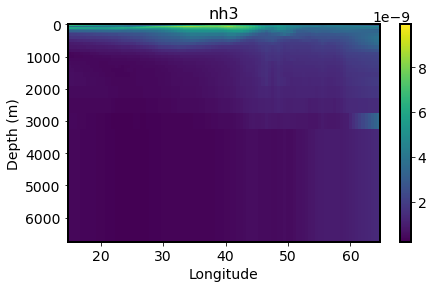

In [22]:
plot_lon = False

### Figure - check ###
plt.rcParams.update(params)

fig, axs = plt.subplots(1, 1, figsize=(7, 4), sharey=False)

if plot_lon:
    pC = axs.pcolormesh(longitude.T, depth0, tracer_in[0,:,0,:])
    fig.colorbar(pC, ax=axs)

#Transect across latitude shows the same pattern
else:
    pT = axs.pcolormesh(latitude.transpose(), depth0, tracer_in[0,:,:,0])
    fig.colorbar(pT, ax=axs)


axs.invert_yaxis()
axs.set_xlabel('Longitude')
axs.set_ylabel('Depth (m)')
axs.set_title(tracers[itrac])

In [23]:
# Check file
# ds.close()
# ds = xr.open_dataset(spath + 'DG_init_tracers.nc')
# ds

# Separate NH_3 initialization file
Unsure why and currently not used (triggers an error at run time)

In [24]:
# Load global model output for NH3
# Our output file currently triggers an error at run time
# Will troubleshoot if necessary (perhaps due to depth vector)
dsNH3 = xr.open_dataset(mpath + 'init_ocean_cobalt_nh3.res.nc')

In [25]:
# NH3 must be done separately because different depth vector
profNH3   = dsNH3.nh3.sel(yaxis_1=slice(latA1, latA2), xaxis_1=slice(lonA1, lonA2)).mean(dim={'xaxis_1','time'}, skipna=True)

# Isolate depth dimensions
depth0   = dsNH3.zt.values
depth0   = np.resize(depth0, (depth0.size, 1))

profNH3 = profNH3.interp(zt = depth0.T[0], yaxis_1 = latitude.T[0], kwargs={"fill_value": "extrapolate"})

profNH3 = profNH3.values
profNH3[depth0[:,0] > depth0[43,0]] = profNH3[depth0[:,0] == depth0[43,0]]
    
# Repeat the profile everywhere in our domain
NH3_in    = np.array([profNH3 for i in range(len(longitude))])
NH3_in    = np.transpose(NH3_in, (1,2,0))  # depth, latitude, longitude
NH3_in    = np.expand_dims(NH3_in, 0)  # add an extra dimension for 'time' (just one time step)

# Replace NaNs with small value
NH3_in[np.isnan(NH3_in)] = fillval

Text(0.5, 1.0, 'nh3')

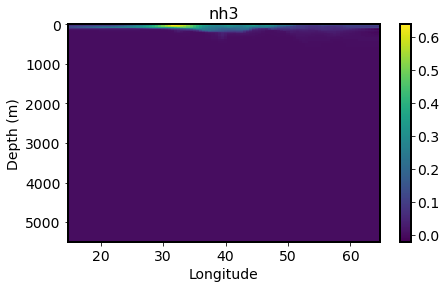

In [26]:
plot_lon = False

### Figure - check ###
plt.rcParams.update(params)

fig, axs = plt.subplots(1, 1, figsize=(7, 4), sharey=False)

if plot_lon:
    pC = axs.pcolormesh(longitude.T, depth0, NH3_in[0,:,0,:])
    fig.colorbar(pC, ax=axs)

#Transect across latitude shows the same pattern
else:
    pT = axs.pcolormesh(latitude.transpose(), depth0, NH3_in[0,:,:,0])
    fig.colorbar(pT, ax=axs)


axs.invert_yaxis()
axs.set_xlabel('Longitude')
axs.set_ylabel('Depth (m)')
axs.set_title(tracers[itrac])

In [27]:
# From Elizabeth's MOM6 Example
writing = nc.Dataset(spath + "DG_init_nh3.nc","w",format="NETCDF3_64BIT_OFFSET")
time    = writing.createDimension("time", 1)
depth   = writing.createDimension("depth", len(depth0))
lat     = writing.createDimension("lat", len(latitude))
lon     = writing.createDimension("lon", len(longitude))

lat     = writing.createVariable("lat","f8",("lat"))
lat[:]  = latitude
lat.standard_name    = "latitude"
lat.units            = "degrees_north"
lat.cartesian_axis   = "Y"
 
lon     = writing.createVariable("lon","f8",("lon"))
lon[:]  = longitude
lon.standard_name    = "longitude"
lon.units            = "degrees_east"
lon.cartesian_axis   = "X" ;

time    = writing.createVariable("time","f8",("time"))
time[:] = 0.0
time.standard_name   = "time"
time.units           = "days since 0001-01-01 00:00:00"
time.calendar        = "noleap" ;
time.cartesian_axis  = "T" ;
    
depth    = writing.createVariable("depth","f8",("depth"))
depth[:] = depth0
depth.standard_name  = "depth"
depth.units          = "m"
depth.positive       = "down"
depth.cartesian_axis = "Z" ;

NH3          = writing.createVariable("nh3","f4",("time","depth","lat","lon"),fill_value=fillval)
NH3[:,:,:,:] = NH3_in
# The tracers in the file do not seem to have descriptions so not included

# Write file
writing.close()

In [27]:
# Check file
# ds.close()
# ds = xr.open_dataset(spath + 'DG_init_nh3.nc')
# ds

In [28]:
# The two sources of NH3 profiles are clearly different but unsure why...
# fig, ax = plt.subplots(1, 1, figsize=(3, 5))

# profM.nh3.plot(y='z_l', ax=ax, color='red')
# profNH3.nh3.plot(y='zt', ax=ax, color='blue', linestyle='dashed')

# ax.invert_yaxis()